In [1]:
try:
    import breaching
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    import os; os.chdir("..")
    import breaching
    
import torch
%load_ext autoreload
%autoreload 2

# Redirects logs directly into the jupyter notebook
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

In [80]:
from omegaconf import OmegaConf, open_dict
cfg = breaching.get_config(overrides=[
    "case=mask_image_custom",
    "attack=Adam_DLG",
    "case/user=local_updates"])
          
device = torch.device(f'cuda:0') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

num_data_points = [2]
num_local_updates = [2]
num_data_per_local_update_step = [1]
num_trials = 100
total_shared_data = []
for num_trial in range(num_trials):
    for a, b, c in zip(num_data_points, num_local_updates, num_data_per_local_update_step):
        with open_dict(cfg):
            cfg.case.user.num_data_points = a
            cfg.case.user.num_local_updates = b
            cfg.case.user.num_data_per_local_update_step = c
            cfg.seed = num_trial
            cfg.case.user.local_learning_rate = 0.01
        model, loss_fn = breaching.cases.construct_model(cfg.case.model, cfg.case.data, cfg.case.server.pretrained)
        server = breaching.cases.construct_server(model, loss_fn, cfg.case, setup)
        model = server.vet_model(model)
        attacker = breaching.attacks.prepare_attack(model, loss_fn, cfg.attack, setup)
        user = breaching.cases.construct_user(model, loss_fn, cfg.case, setup)
        overview = breaching.utils.return_overview(server, user, attacker)
        shared_user_data, payloads, true_user_data = server.run_protocol(user)
        total_shared_data.append(shared_user_data)

        print(overview)

Investigating use case image_custom with server type honest_but_curious.
Files already downloaded and verified
Computing user update on user 0 in model mode: eval.
Model architecture custom_McMahan_32_32 loaded with 2,156,490 parameters and 0 buffers.Overall this is a data ratio of     351:1 for target shape [2, 3, 32, 32] given that num_queries=1.User (of type UserMultiStep) with settings:
    Number of data points: 2

    Threat model:
    User provides labels: True
    User provides buffers: False
    User provides number of data points: True

    Data:
    Dataset: CIFAR10
    user: 0
    
        
    Local FL Setup:
        Number of local update steps: 2
        Data per local update step: 1
        Local learning rate: 0.01

        Threat model:
        Share these hyperparams to server: True
        Share local learning rate to server: True

        Server (of type HonestServer) with settings:
    Threat model: Honest-but-curious
    Number of planned queries: 1
    Has exter

In [57]:
total_shared_data[i][0]["gradients"][-2:][0].shape

torch.Size([10, 512])

In [81]:
total_last_weight = torch.stack([total_shared_data[i][0]["gradients"][-2:][0] for i in range(len(total_shared_data))], dim=0)
total_last_bias = torch.stack([total_shared_data[i][0]["gradients"][-2:][1] for i in range(len(total_shared_data))], dim=0)
total_label = torch.stack([total_shared_data[i][0]["metadata"]["labels"] for i in range(len(total_shared_data))], dim=0)
print(total_last_weight.shape)
print(total_last_bias.shape)
print(total_label.shape)

res = torch.min(total_last_weight, dim=-1).values
first_res  = torch.stack([res[i][total_label[i][0]] for i in range(len(res))])
first_res_second_res = torch.stack([res[i][total_label[i][1]] for i in range(len(res))])
second_res = torch.stack([res[i][total_label[i][1]] for i in range(len(res))])
second_res_first_res = torch.stack([res[i][total_label[i][0]] for i in range(len(res))])

print(f"First : min={first_res.min().item():.8f}, max={first_res.max().item():.8f}, mean={first_res.mean().item():.8f}, std={first_res.std().item():.8f}")
print(f"Second: min={second_res.min().item():.8f}, max={second_res.max().item():.8f}, mean={second_res.mean().item():.8f}, std={second_res.std().item():.8f}")
# for i in range(10):
#     shared_user_data = total_shared_data[i]
#     # print(shared_user_data[0].keys())
#     last_weight, last_bias = shared_user_data[0]["gradients"][-2:]

#     # print("Last weight:", last_weight)
#     # print("Last weight shape:", last_weight.shape)
#     # print("Last bias:", last_bias)
#     # print("Last bias shape:", last_bias.shape)
#     print("metadata:", {shared_user_data[0]["metadata"]["labels"]})

#     labelwise_weight = last_weight[shared_user_data[0]["metadata"]["labels"]]
#     for i in range(len(labelwise_weight)):
#         print(f"Dimension {i}: min: {labelwise_weight[i].min():.5f}, max: {labelwise_weight[i].max():.5f}, mean: {labelwise_weight[i].mean():.5f}, std: {labelwise_weight[i].std():.5f}")


torch.Size([100, 10, 512])
torch.Size([100, 10])
torch.Size([100, 2])
First : min=-0.00064757, max=0.00000000, mean=-0.00025442, std=0.00012517
Second: min=-0.00046052, max=0.00000000, mean=-0.00021776, std=0.00009621


In [82]:
# print((torch.argmax(res, dim=1) == total_label[:, 0]).sum().item() / len(res))

res_label = torch.topk(res, k=2, dim=1).indices

print((res_label[:, 0] == total_label[:, 0]).sum().item() / len(res))
print((res_label[:, 1] == total_label[:, 1]).sum().item() / len(res))

(first_res <= second_res).sum().item() / len(res)

0.41
0.32


0.68

In [36]:
print(total_last_weight.shape)
print(total_last_bias.shape)

torch.Size([100, 10, 512])
torch.Size([100, 10])


In [75]:
print(f"{a.mean().item():.8f}", f"{a.std().item():.8f}")
print(f"{b.mean().item():.8f}", f"{b.std().item():.8f}")


-0.00051297 0.01693507
0.00992077 0.02119698


tensor(5.9493e-06)
tensor(3.8888e-06)
tensor(-5.9046e-07)
tensor(5.9512e-06)
tensor(3.8877e-06)


[]

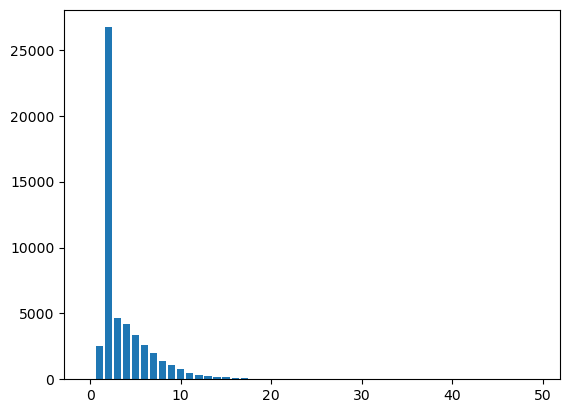

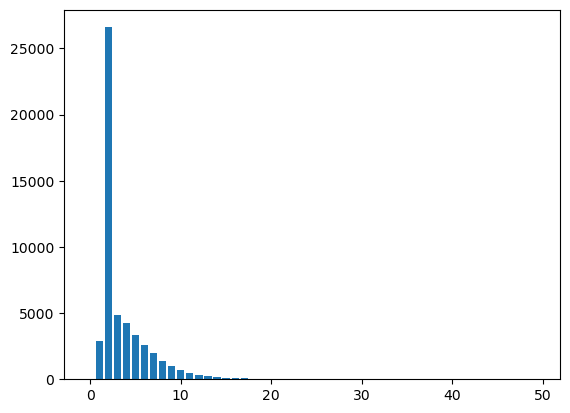

In [79]:
import matplotlib.pyplot as plt

a = torch.stack([total_last_weight[i, total_label[i, 0], :] for i in range(len(total_label))])
b = torch.stack([total_last_weight[i, total_label[i, 1], :] for i in range(len(total_label))])

plt.figure()
bins = 50
hist = torch.histogram(a.cpu(), bins = bins)
x = range(bins)
print(hist.bin_edges.mean())
print(hist.bin_edges.std())
print(hist.bin_edges.min())
plt.bar(x, hist.hist, align='center')
plt.plot()

plt.figure()
bins = 50
hist = torch.histogram(b.cpu(), bins = bins)
x = range(bins)
print(hist.bin_edges.mean())
print(hist.bin_edges.std())
plt.bar(x, hist.hist, align='center')
plt.plot()

# plt.hist(total_last_weight.cpu().numpy(), bins=10)